# Experiments with Model 2

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1.5 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current

In [3]:
def build_network(
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        seed = 0,
        nNeurons = 100,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        intercept_LA_pyr = -0.2,
        lr1 = 3e-5,
        lr2 = 1e-4,
        lr3 = 1e-5,
        T_BLA_CS=0.25,
        T_BLA_CTX=0.75,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)
    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)
    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])
    dInh = -3e0*np.ones((nNeurons, 1))

    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        applied_current = nengo.Node(lambda t, x: inputs.get_applied_current(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(LA_pyr[1], LA_inh[1])
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=T_BLA_CS)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[2], CeM, transform=T_BLA_CTX)  # CTX response added to total fear response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
        # error connections
        nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
        nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
        nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
        nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)
        # stop learning during testing
        nengo.Connection(stop_learning, error_LA.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_CeL.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=-1e3*np.ones((nNeurons, 1)))

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.applied_current = applied_current
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

## Fear Expression and Neural Responses

In [4]:
def fear_expression_neural_responses(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
        plot=False,
    ):

    if load:
        data_fear = pd.read_pickle("fear_expression.pkl")
        data_activity = pd.read_pickle("neural_responses.pkl")        
        data_types = pd.read_pickle("neuron_types.pkl")        
    else:
        data_fear = pd.DataFrame(columns=["seed", "Fear Response", "Experiment"])
        data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
        data_types = pd.DataFrame(columns=["seed", "Type", "Percent"])
        rng = np.random.RandomState(seeds)

        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(8e-5, 2e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.stop_learning = 0
                print("control")
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                print("conditioning")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2+2*nCond-1)/dt)
                T2b = int((2+2*nCond-0.5)/dt)
                print("extinction")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                for p in range(nExt):
                    sim.run(2)
                T3a = int((2+2*nCond+2*nExt-1)/dt)
                T3b = int((2+2*nCond+2*nExt-0.5)/dt)
        #         print("turn learning off for testing")
                net.inputs.stop_learning = 1
                print("test CTX A")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T4a = int((2+2*nCond+2*nExt+1)/dt)
                T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                print("test CTX B")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)  
                print("test CTX C")
                net.inputs.CTX = net.inputs.CTXs[2]
                net.inputs.US = 0
                sim.run(2)
                T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
                T6b = int((2+2*nCond+2*nExt+2+2+1.5)/dt)  

            if plot:
                ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                ctx_signal = np.zeros((sim.trange().shape[0]))
                ctx_signal2 = np.zeros((sim.trange().shape[0]))
                ctx_signal[ctxB_idx] = 1
                ctx_signal2[ctxC_idx] = 0.5
                fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                axes[0].plot(sim.trange(), sim.data[net.pCeM])
                axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                axes[1].plot(sim.trange(), ctx_signal)
                axes[1].plot(sim.trange(), ctx_signal2)
                axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                axes[2].legend()
                axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                axes[3].legend()
                axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                plt.tight_layout()

            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]),
                "Experiment": "Control"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]),
                "Experiment": "CS and CTX+"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]),
                "Experiment": "CS and CTX-"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T6a: T6b]),
                "Experiment": "CS+ and CTXn"},
                ignore_index=True)

            aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
            aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T4a: T4b]
            aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
            aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
            aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T4a: T4b]
            aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
            aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
            aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T4a: T4b]
            aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
            aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
            aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T4a: T4b]
            aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    

            LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
            LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
            fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
            fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
            fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
            extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
            persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Experiment": "Extinction"}, ignore_index=True)

            percent_up = len(LA_pyr_up)/(2*nNeurons)*100
            percent_down = len(LA_pyr_down)/(2*nNeurons)*100
            percent_fear = len(fear_neurons)/(4*nNeurons)*100
            percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
            percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
            data_types = data_types.append({"seed": seed, "Type": "LA up", "Percent": percent_up}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "LA down", "Percent": percent_down}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Extinct", "Percent": percent_extinction}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Persist", "Percent": percent_persistent}, ignore_index=True)

        data_fear.to_pickle("fear_expression.pkl")
        data_activity.to_pickle("neural_responses.pkl")
        data_types.to_pickle("neuron_types.pkl")
            
    fig, ax = plt.subplots(figsize=((6.38,2)))
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette)
    ax.set(xlabel=None, yticks=((0,1)), title="Fear Expression")
    plt.tight_layout()
    fig.savefig("model2_fear_expression.svg")
    fig.savefig("model2_fear_expression.png", dpi=600)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38,3)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
    ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)", title="Neural Responses")
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.savefig("model2_neuron_responses.svg")
    fig.savefig("model2_neuron_responses.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=((6.38,2)), sharey=True)
    sns.histplot(data=data_types.query("Type=='LA up'")['Percent'], stat="percent", bins=10, ax=axes[0])
    sns.histplot(data=data_types.query("Type=='LA down'")['Percent'], stat="percent", bins=10, ax=axes[1])
    sns.histplot(data=data_types.query("Type=='BLA Fear'")['Percent'], stat="percent", bins=10, ax=axes[2])
    sns.histplot(data=data_types.query("Type=='BLA Persist'")['Percent'], stat="percent", bins=10, ax=axes[3])
    sns.histplot(data=data_types.query("Type=='BLA Extinct'")['Percent'], stat="percent", bins=10, ax=axes[4])
    axes[0].set(title="LA Up", ylabel="Frequency of observation\nacross networks")
    axes[1].set(title="LA Down")
    axes[2].set(title="BLA Fear")
    axes[3].set(title="BLA Persist")
    axes[4].set(title="BLA Extinct")
    plt.tight_layout()
    fig.savefig("model2_neuron_types.svg")
    fig.savefig("model2_neuron_types.png", dpi=600)


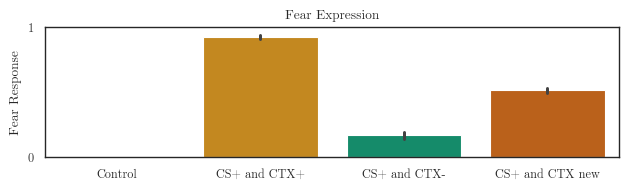

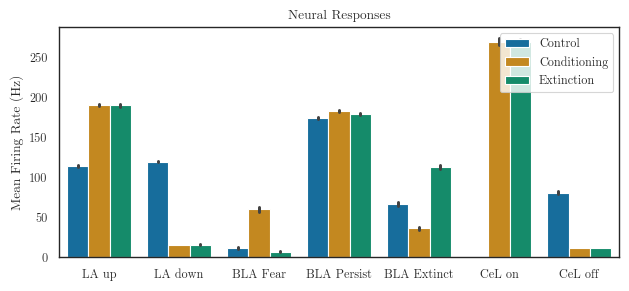

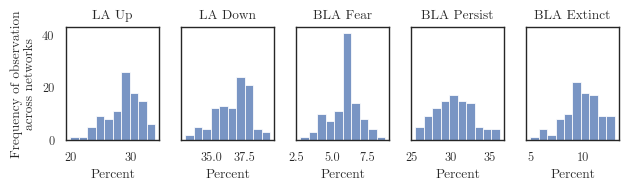

In [6]:
fear_expression_neural_responses(seeds=100, plot=False, load=False)

## Activation and Inactivation

In [9]:
def activation_inactivation(
        seeds=2,
        target="LA_pyr",
        stims=["Activate", "Inactivate"],
        blocks=[
            "Before\nTraining",
            "Conditioning\nTraining",
            "Conditioning\nTesting",
            "Extinction\nTraining",
            "Extinction\nTesting"],
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCTX=2,
        nCS=1,
        T_current=1e1,
        load=False,
        redo_baseline=False
    ):

    rng = np.random.RandomState(seeds)

    if redo_baseline:
        data_baseline = pd.DataFrame(columns=["seed", "Fear Response", "Stimulus", "Block", "Test"])
        for seed in range(seeds):
            print(f"baseline")
            rng = np.random.RandomState(seed)
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(8e-5, 2e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                # control
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                # conditioning
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2)/dt)
                T2b = int((2+2*nCond)/dt)
                # test (conditioning)
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T3a = int((2+2*nCond+1)/dt)
                T3b = int((2+2*nCond+1.5)/dt)      
                # extinction 
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                for p in range(nExt):
                    sim.run(2)
                T4a = int((2+2*nCond+2)/dt)
                T4b = int((2+2*nCond+2+2*nExt)/dt)
                # test (extinction)
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2+2*nExt+1)/dt)
                T5b = int((2+2*nCond+2+2*nExt+1.5)/dt)
            for block in blocks:
                data_baseline = data_baseline.append({"seed": seed, "Test" :"Spontaneous", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Block": block}, ignore_index=True)
                data_baseline = data_baseline.append({"seed": seed, "Test" :"Conditioning", "Fear Response": np.mean(sim.data[net.pCeM][T3a: T3b]), "Block": block}, ignore_index=True)
                data_baseline = data_baseline.append({"seed": seed, "Test" :"Extinction", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Block": block}, ignore_index=True)
        data_baseline.to_pickle(f"activation_baseline.pkl")
    else:
        data_baseline = pd.read_pickle(f"activation_baseline.pkl")


    if load:
        data = pd.read_pickle(f"activation_{target}.pkl")    
    else:
        data = pd.DataFrame(columns=["seed", "Fear Response", "Stimulus", "Block", "Test"])
        for seed in range(seeds):
            for stim in stims:
                for block in blocks:
                    print(f"seed={seed}, target={target}, block={block}, stim={stim}")
                    lr1 = rng.uniform(2e-5, 4e-5)
                    lr2 = rng.uniform(8e-5, 2e-4)
                    lr3 = rng.uniform(8e-6, 2e-5)
                    T_BLA_CS = rng.uniform(0.2, 0.4)
                    T_BLA_CTX = rng.uniform(0.5, 1.0)
                    net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                        dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
                    with net:
                        if target=="LA_pyr":
                            nengo.Connection(net.applied_current, net.LA_pyr.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
                        if target=="LA_inh":
                            nengo.Connection(net.applied_current, net.LA_inh.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
                        if target=="BLA_pyr":
                            nengo.Connection(net.applied_current, net.BLA_pyr.neurons, transform=T_current*np.ones((3*nNeurons, 1)))
                        if target=="BLA_inh":
                            nengo.Connection(net.applied_current, net.BLA_inh.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
                        if target=="CeL":
                            nengo.Connection(net.applied_current, net.CeL_on.neurons, transform=T_current*np.ones((nNeurons, 1)))
                            nengo.Connection(net.applied_current, net.CeL_off.neurons, transform=T_current*np.ones((nNeurons, 1)))
                        if target=="CeM":
                            nengo.Connection(net.applied_current, net.CeM.neurons, transform=T_current*np.ones((nNeurons, 1)))
                    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
                    with sim:
                        # control
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 0
                        if block=="Before\nTraining" and stim=="Activate":
                            net.inputs.applied_current = 1
                        elif block=="Before\nTraining" and stim=="Inactivate":
                            net.inputs.applied_current = -1
                        else:
                            net.inputs.applied_current = 0
                        sim.run(2)
                        T1a = int(1/dt)
                        T1b = int(2/dt)
                        # conditioning
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 1
                        if block=="Conditioning\nTraining" and stim=="Activate":
                            net.inputs.applied_current = 1
                        elif block=="Conditioning\nTraining" and stim=="Inactivate":
                            net.inputs.applied_current = -1
                        else:
                            net.inputs.applied_current = 0
                        for p in range(nCond):
                            sim.run(2)
                        T2a = int((2)/dt)
                        T2b = int((2+2*nCond)/dt)
                        # test (conditioning)
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 0
                        if block=="Conditioning\nTesting" and stim=="Activate":
                            net.inputs.applied_current = 1
                        elif block=="Conditioning\nTesting" and stim=="Inactivate":
                            net.inputs.applied_current = -1
                        else:
                            net.inputs.applied_current = 0
                        sim.run(2)
                        T3a = int((2+2*nCond+1)/dt)
                        T3b = int((2+2*nCond+1.5)/dt)      
                        # extinction 
                        net.inputs.CTX = net.inputs.CTXs[1]
                        net.inputs.US = 0
                        if block=="Extinction\nTraining" and stim=="Activate":
                            net.inputs.applied_current = 1
                        elif block=="Extinction\nTraining" and stim=="Inactivate":
                            net.inputs.applied_current = -1
                        else:
                            net.inputs.applied_current = 0
                        for p in range(nExt):
                            sim.run(2)
                        T4a = int((2+2*nCond+2)/dt)
                        T4b = int((2+2*nCond+2+2*nExt)/dt)
                        # test (extinction)
                        net.inputs.CTX = net.inputs.CTXs[1]
                        net.inputs.US = 0
                        if block=="Extinction\nTesting" and stim=="Activate":
                            net.inputs.applied_current = 1
                        elif block=="Extinction\nTesting" and stim=="Inactivate":
                            net.inputs.applied_current = -1
                        else:
                            net.inputs.applied_current = 0
                        sim.run(2)
                        T5a = int((2+2*nCond+2+2*nExt+1)/dt)
                        T5b = int((2+2*nCond+2+2*nExt+1.5)/dt)

                    data = data.append({"seed": seed, "Test" :"Spontaneous", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Stimulus": stim, "Block": block},ignore_index=True)
                    data = data.append({"seed": seed, "Test" :"Conditioning", "Fear Response": np.mean(sim.data[net.pCeM][T3a: T3b]), "Stimulus": stim, "Block": block}, ignore_index=True)
                    data = data.append({"seed": seed, "Test" :"Extinction", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Stimulus": stim, "Block": block}, ignore_index=True)

        data.to_pickle(f"activation_{target}.pkl")

#     sns.set(context='paper', style='whitegrid', font='CMU Serif')
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True)
    bar1 = sns.barplot(data=data.query("Stimulus=='Inactivate'"), x='Block', y='Fear Response', hue="Test", ax=axes[0])
    bar2 = sns.barplot(data=data_baseline, x='Block', y='Fear Response', hue="Test", ax=axes[1])
    bar3 = sns.barplot(data=data.query("Stimulus=='Activate'"),x='Block', y='Fear Response', hue="Test", ax=axes[2])
    axes[0].set(ylabel="Inhibition", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
    axes[1].set(ylabel="Baseline", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
    axes[2].set(ylabel="Activation", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel="External Stimulus Applied During Stage X")
    axes[0].get_legend().remove()
    axes[2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"activation_inactivation_{target}.png", dpi=600)
    fig.savefig(f"activation_inactivation_{target}.svg")

In [ ]:
activation_inactivation(seeds=1, target="LA_pyr", load=False, redo_baseline=True)

baseline
seed=0, target=LA_pyr, block=Before
Training, stim=Activate
seed=0, target=LA_pyr, block=Conditioning
Training, stim=Activate
seed=0, target=LA_pyr, block=Conditioning
Testing, stim=Activate
seed=0, target=LA_pyr, block=Extinction
Training, stim=Activate
seed=0, target=LA_pyr, block=Extinction
Testing, stim=Activate


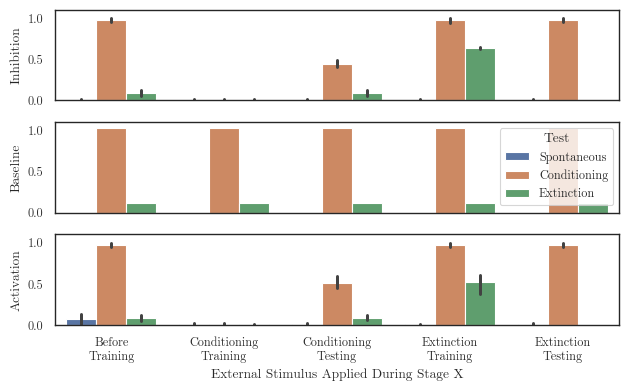

In [29]:
activation_inactivation(seeds=5, target="LA_pyr", load=True, redo_baseline=False)

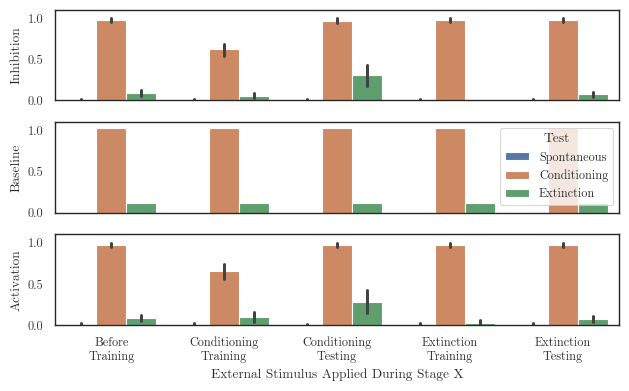

In [30]:
activation_inactivation(seeds=5, target="LA_inh", load=True, redo_baseline=False)

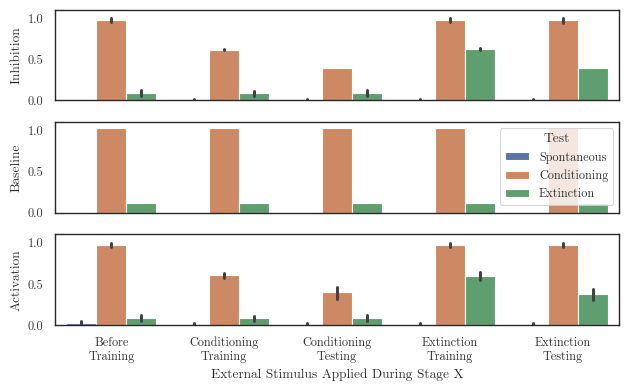

In [31]:
activation_inactivation(seeds=5, target="BLA_pyr", load=True, redo_baseline=False)

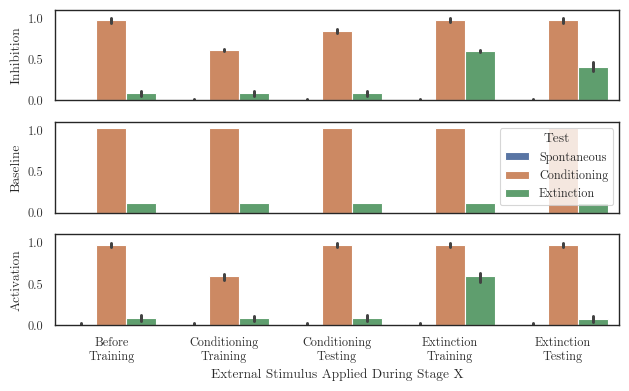

In [32]:
activation_inactivation(seeds=5, target="BLA_inh", load=True, redo_baseline=False)

In [35]:
activation_inactivation(seeds=5, target="CeL", load=False, redo_baseline=False)

seed=0, target=CeL, block=Before
Training, stim=Activate


KeyboardInterrupt: 

In [ ]:
activation_inactivation(seeds=5, target="CeM", load=False, redo_baseline=False)

## Fear Generalization

In [15]:
def generalization(
        experiment,
        seeds=5,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nCS=1,
        nCTX=2,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0,
        intercept_CTX=0,
        plot=False,
    ):

    rng = np.random.RandomState(seeds)
    if experiment=="CS":
        data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CS+"])
    elif experiment=="CTX":
        data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CTX+", "Similarity to CTX-"])

    for s in range(seeds):
        print(f"seed={s}")
        seed = s
        lr1 = rng.uniform(2e-5, 4e-5)
        lr2 = rng.uniform(8e-5, 2e-4)
        lr3 = rng.uniform(8e-6, 2e-5)
        T_BLA_CS = rng.uniform(0.2, 0.4)
        T_BLA_CTX = rng.uniform(0.5, 1.0)
        net = build_network(
            seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
            intercept_CS=intercept_CS, intercept_CTX=intercept_CTX,
            dt=dt, nNeurons=nNeurons,
            nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
        sim = nengo.Simulator(net, dt=dt, progress_bar=False)
        with sim:
            print("acquisition")
            net.inputs.stop_learning = 0
            CTXplus = net.inputs.CTXs[0]
            CSplus = net.inputs.CSs[0]
            net.inputs.US = 1
            net.inputs.CS = CSplus
            net.inputs.CTX = CTXplus
            for p in range(nCond):
                sim.run(2)
            print("extinction")
            CTXminus = net.inputs.CTXs[1]
            net.inputs.CS = 0
            net.inputs.US = 0
            net.inputs.CTX = CTXminus
            for p in range(nExt):
                sim.run(2)
            print("testing")
            net.inputs.stop_learning = 1
            net.inputs.US = 0
            if experiment=="CS":
                for cs in range(nCS):
                    print(f"CS {cs}")
                    CS = net.inputs.CSs[cs]
                    net.inputs.CS = CS
                    net.inputs.CTX = CTXplus
                    sim.run(2)
                    freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                    similarity = np.dot(CSplus, CS)
                    data = data.append({
                        "seed": seed,
                        "Fear Response": freezing,
                        "Similarity to CS+": similarity
                    }, ignore_index=True)
            elif experiment=="CTX":
                for ctx in range(nCTX):
                    print(f"CTX {ctx}")
                    CTX = net.inputs.CTXs[ctx]
                    net.inputs.CTX = CTX
                    net.inputs.CS = 0
                    net.inputs.US = 0
                    sim.run(2)
                    freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                    similarity_plus = np.dot(CTXplus, CTX)
                    similarity_minus = np.dot(CTXminus, CTX)
                    data = data.append({
                        "seed": seed,
                        "Fear Response": freezing,
                        "Similarity to CTX+": similarity_plus,
                        "Similarity to CTX-": similarity_minus,
                    }, ignore_index=True)

    if plot:
        ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
        ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
        ctx_signal = np.zeros((sim.trange().shape[0]))
        ctx_signal[ctxB_idx] = 1

        fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=((6.38,6)), gridspec_kw={'height_ratios': [1,2,2,2,2,3]})
        axes[0].plot(sim.trange(), sim.data[net.pCeM], label="CeM")
        axes[0].set(ylabel=r"$\hat{x}$", yticks=((0,1)))  #  title="Fear Response",
        axes[0].legend(loc='upper right')
        axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS")
        axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
        axes[1].plot(sim.trange(), ctx_signal, label="CTX")
        axes[1].legend(loc='upper right')
        axes[1].set(ylabel=None,  yticks=(()))  # , title="Stimuli")
        axes[2].plot(sim.trange(), sim.data[net.pLA_pyr][:,0], label="LA_pyr_CS")
        axes[2].plot(sim.trange(), sim.data[net.pLA_pyr][:,1], label="LA_pyr_US")
        axes[2].legend(loc='upper right')
        axes[2].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel=r"$\hat{x}$")  # , title="LA Decoded Values")
        axes[3].plot(sim.trange(), sim.data[net.pCeL_on], label="CeL_on")
        axes[3].plot(sim.trange(), sim.data[net.pCeL_off], label="CeL_off")
        axes[3].legend(loc='upper right')
        axes[3].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel=r"$\hat{x}$")  # , title="CeL Decoded Values")
        axes[4].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
        axes[4].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
        axes[4].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
        axes[4].legend(loc='upper right')
        axes[4].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$")  # , title="BLA Decoded Values")
        axes[5].plot(sim.trange(), sim.data[net.pError_LA], label="US minus CS (LA)")
        axes[5].plot(sim.trange(), sim.data[net.pError_LA], label="CS (LA) - CS (CeL)")
        axes[5].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS plus CTX (BLA)")
        axes[5].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX (BLA)")
        axes[5].legend(loc='upper right')
        axes[5].set(xlabel='time (s)', xticks=np.arange(0, 34, 2), ylabel=r"$\hat{x}$", yticks=((0,1)))  #  title="Errors",
        plt.tight_layout()
    
    if experiment=="CS":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CS}.pkl")
        fig, ax = plt.subplots(figsize=((8,4)))
        sns.scatterplot(data=data, x='Similarity to CS+', y="Fear Response", ax=ax)
        ax.set(title=f"CS Generalization, intercept={intercept_CS}")
        plt.tight_layout()
        fig.savefig(f"generalization_{experiment}_intercept{intercept_CS}.svg")
        fig.savefig(f"generalization_{experiment}_intercept{intercept_CS}.png", dpi=600)
        
    if experiment=="CTX":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CTX}.pkl")
        fig, ax = plt.subplots(figsize=((8,4)))
        sns.scatterplot(data=data, x='Similarity to CTX+', y="Similarity to CTX-",
            hue="Fear Response", size="Fear Response", palette="viridis", ax=ax)
        ax.set(xlim=((-1.1,1.1)), ylim=((-1.1,1.1)), title=f"CS Generalization, intercept={intercept_CS}")
        plt.tight_layout()
        fig.savefig(f"generalization_{experiment}_intercept{intercept_CTX}.svg")
        fig.savefig(f"generalization_{experiment}_intercept{intercept_CTX}.png", dpi=600)

seed=0
acquisition
extinction
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29


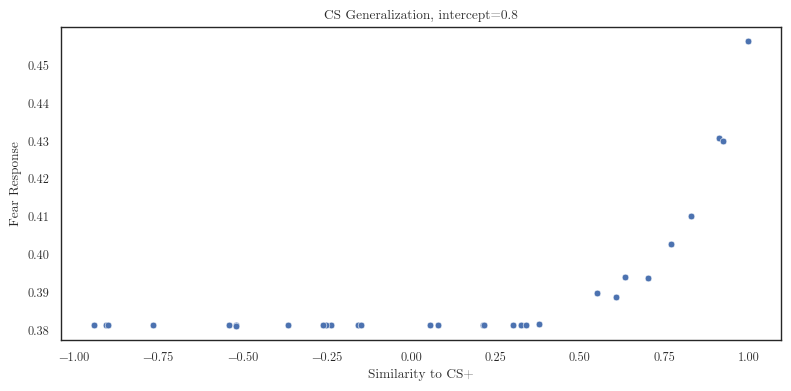

In [17]:
generalization(experiment="CS", seeds=1, nCS=300, intercept_CS=0.8, plot=False)

In [ ]:
generalization(experiment="CS", seeds=1, nCS=300, intercept_CS=0.6, plot=False)

In [ ]:
generalization(experiment="CS", seeds=1, nCS=300, intercept_CS=0.4, plot=False)

seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9


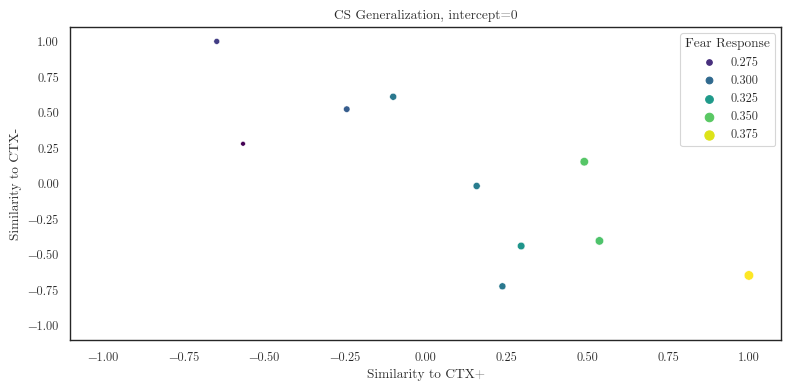

In [18]:
generalization(experiment="CTX", seeds=1, nCTX=300, intercept_CTX=-0.6, plot=False)

In [ ]:
generalization(experiment="CTX", seeds=1, nCTX=300, intercept_CTX=0, plot=False)

In [ ]:
generalization(experiment="CTX", seeds=1, nCTX=300, intercept_CTX=0.6, plot=False)